In [1]:
#COMPLETE_RUN = False
import numpy as np
np.random.seed(1001)
import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
train = pd.read_csv("/Users/vaithili/4thyearproject/all/train_music.csv")
#test = pd.read_csv("/Users/vaithili/4thyearproject/all/sample_submission.csv")

In [3]:
train.head()

,fname,label,manually_verified
0,001ca53d.wav,Saxophone,1
1,002d256b.wav,Trumpet,0
2,0033e230.wav,Glockenspiel,1
3,00353774.wav,Cello,1
4,003b91e8.wav,Cello,0


In [4]:
print("Number of training examples=", train.shape[0], "  Number of classes=", len(train.label.unique()))

Number of training examples= 4336   Number of classes= 17


In [5]:
print(train.label.unique())

['Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Clarinet' 'Snare_drum'
 'Oboe' 'Flute' 'Chime' 'Bass_drum' 'Harmonica' 'Gong' 'Double_bass'
 'Tambourine' 'Electric_piano' 'Acoustic_guitar' 'Violin_or_fiddle']


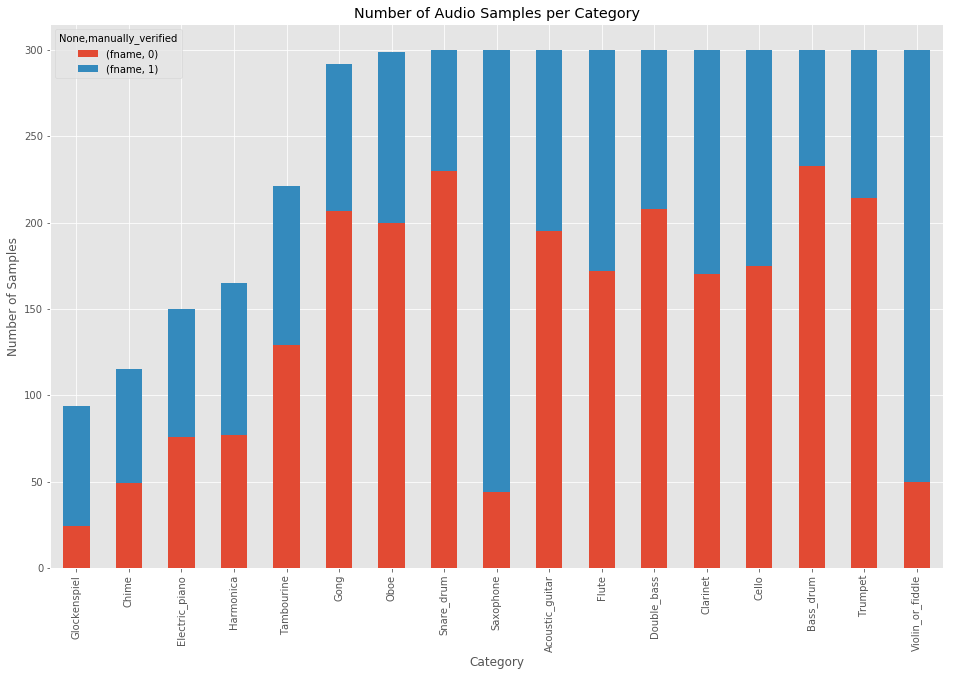

In [6]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [7]:
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


In [8]:
import IPython.display as ipd  # To play sound in the notebook
fname = '/Users/vaithili/4thyearproject/all/audio_musical_train/' + '00f88dc5.wav'   # Hi-hat
ipd.Audio(fname)

In [9]:
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  352800
Duration =  8.0


In [10]:
# Using scipy
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (352800,)
[  14  -41 -194 ...   -1    1   -1]


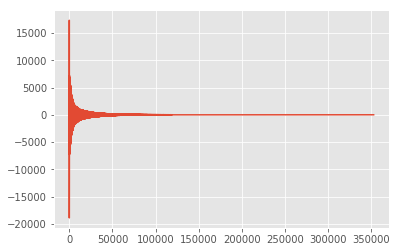

In [11]:
plt.plot(data, '-', );

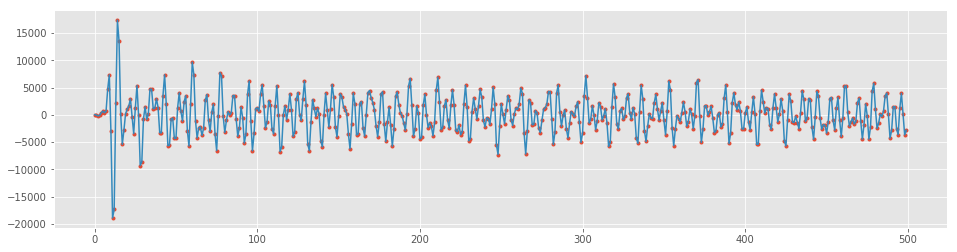

In [12]:
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

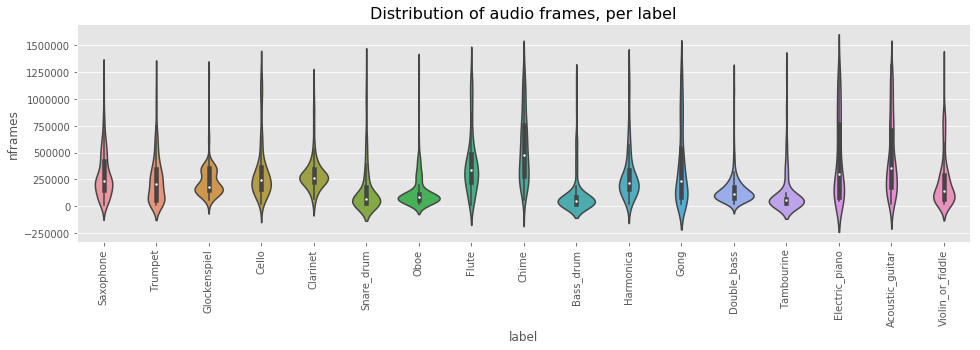

In [13]:
train['nframes'] = train['fname'].apply(lambda f: wave.open('/Users/vaithili/4thyearproject/all/audio_musical_train/' + f).getnframes())
#test['nframes'] = test['fname'].apply(lambda f: wave.open('C:/Users/Aiswaryaa/Desktop/all/audio_test/audio_test/' + f).getnframes())

_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

In [14]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

Using TensorFlow backend.


In [15]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=17,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [18]:
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])

In [19]:
train.head()
print(train.shape)

(4336, 4)


In [20]:
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K
import keras_metrics

In [21]:
def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    print(inp.shape)
    x = Convolution2D(64, (2,2), padding="same")(inp)
    print(x.shape)
    x = BatchNormalization()(x)
    print(x.shape)
    x = Activation("relu")(x)
    print(x.shape)
    x = MaxPool2D()(x)
    print(x.shape)
    print("end")
    
    x = Convolution2D(64, (2,2), padding="same")(x)
    print(x.shape)
    x = BatchNormalization()(x)
    print(x.shape)
    x = Activation("relu")(x)
    print(x.shape)
    x = MaxPool2D()(x)
    print(x.shape)
    print("end")
    
    x = Convolution2D(64, (3,3), padding="same")(x)
    print(x.shape)
    x = BatchNormalization()(x)
    print(x.shape)
    x = Activation("relu")(x)
    print(x.shape)
    x = MaxPool2D()(x)
    print(x.shape)
    print("end")
    
    x = Convolution2D(64, (3,3), padding="same")(x)
    print(x.shape)
    x = BatchNormalization()(x)
    print(x.shape)
    x = Activation("relu")(x)
    print(x.shape)
    x = MaxPool2D()(x)
    print(x.shape)
    print("end")
    
    x = Convolution2D(64, (7,7), padding="same")(x)
    print(x.shape)
    x = BatchNormalization()(x)
    print(x.shape)
    x = Activation("relu")(x)
    print(x.shape)
    x = MaxPool2D()(x)
    print(x.shape)
    print("end")
    
    x = Convolution2D(64, (7,7), padding="same")(x)
    print(x.shape)
    x = BatchNormalization()(x)
    print(x.shape)
    x = Activation("relu")(x)
    print(x.shape)
    print("end")
    
    x = Flatten()(x)
    print(x.shape)
    x = Dense(64)(x)
    print(x.shape)
    x = BatchNormalization()(x)
    print(x.shape)
    x = Activation("relu")(x)
    print(x.shape)
    out = Dense(nclass, activation=softmax)(x)
    print(out.shape)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [22]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=10, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=40)

In [23]:
def prepare_data(df, config, data_dir):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in enumerate(df.index):
        print(fname)
        file_path = data_dir + fname
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

In [24]:
X=train[:2000]
y=train[:2000]["label_idx"]
#X.drop(["label_idx"], inplace = True, axis = 1)
print(X.head())
print(y.head())
print(X.shape)
print(y.shape)

                     label  manually_verified  nframes  label_idx
fname                                                            
001ca53d.wav     Saxophone                  1   455112          0
002d256b.wav       Trumpet                  0    19404          1
0033e230.wav  Glockenspiel                  1   352800          2
00353774.wav         Cello                  1   199332          3
003b91e8.wav         Cello                  0   585648          3
fname
001ca53d.wav    0
002d256b.wav    1
0033e230.wav    2
00353774.wav    3
003b91e8.wav    3
Name: label_idx, dtype: int64
(2000, 4)
(2000,)


In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train1, test1 = train_test_split(train, test_size=0.2)

In [28]:
print(train1.shape)
print(test2.shape)

(3468, 4)
(868, 4)


In [29]:
X_train = prepare_data(train1, config, '/Users/vaithili/4thyearproject/all/audio_musical_train/')
X_test =  prepare_data(test1, config, '/Users/vaithili/4thyearproject/all/audio_musical_train/')
y_train = to_categorical(train1.label_idx, num_classes=config.n_classes)
y_test=to_categorical(test2.label_idx, num_classes=config.n_classes)

ec76d436.wav
a26b644b.wav
c34853a8.wav
c6e2218c.wav
3c24b853.wav
7f553a15.wav
a8683041.wav
121d766e.wav
72118430.wav
2634b73c.wav
8073923c.wav
14d06c29.wav
be6c0570.wav
06a1dfc0.wav
247ac56f.wav
66fe50dc.wav
d5a2e892.wav
fd3982a5.wav
12d4ec7c.wav
31a0e096.wav
1df3177c.wav
3c66098d.wav
147f4395.wav
93519b51.wav
66b3d587.wav
6cfd79c3.wav
c6f603bf.wav
06b278f7.wav
27a4d0ed.wav
4c8cd1c8.wav
e2ea348e.wav
c3846bb1.wav
dbac4e95.wav
b770ff72.wav
40c2cec1.wav
91d51cde.wav
261ac300.wav
be014d8c.wav
82d4fb44.wav
62ccffe4.wav
74018a88.wav
bb8bd984.wav
8c1d4c50.wav
f5172e7e.wav
385c2814.wav
d9f75b52.wav
10550a6f.wav
5d9ca598.wav
65d7c8a6.wav
bbf857f0.wav
189c7842.wav
8d647117.wav
f30c9ba4.wav
19974149.wav
fe0cb23e.wav
82727fe8.wav
a3b975c1.wav
1176bda6.wav
c02503c7.wav
a48c28b0.wav
c2c5173a.wav
aef27ffa.wav
6963377a.wav
8fb1b5af.wav
fe76c972.wav
289e8e59.wav
d00f9207.wav
0cea4550.wav
47cb5f8d.wav
e5e0718b.wav
590dde92.wav
fcc56f50.wav
a13c3b3b.wav
54777c28.wav
d8013141.wav
5742568e.wav
820ca779.wav

d033f680.wav
6a30339c.wav
902357e2.wav
9503993d.wav
56238daa.wav
ce206b9d.wav
8c78be1b.wav
7fe9ea95.wav
bf7ac315.wav
afdfd283.wav
c83e0fa1.wav
a20d34e8.wav
8bf73516.wav
dae936cc.wav
0886c767.wav
13da16ae.wav
079bb1c3.wav
eb0fae01.wav
3ac0e2ca.wav
89f8b625.wav
7e304d9b.wav
acf11a33.wav
bb5cd4e6.wav
82fa96a7.wav
ab81b78c.wav
89d12569.wav
ed3bb289.wav
3a1b2a66.wav
1441c25b.wav
5e91ed7e.wav
89c2111f.wav
bbd7db75.wav
85bd7e1b.wav
5801a5b3.wav
3ae76b24.wav
d84c8c43.wav
cdeece57.wav
abb0e46e.wav
b742c26a.wav
b0d08034.wav
f3e77609.wav
f57b608c.wav
9ea6f26b.wav
ba849862.wav
d63ce88d.wav
75fecc19.wav
7396e929.wav
06b89bf9.wav
587ee95e.wav
2ac8b94f.wav
66be15fd.wav
80784970.wav
700f6042.wav
67186290.wav
ed125cf8.wav
07f6b1dc.wav
aeee87f3.wav
75916a91.wav
e3bf6148.wav
bf4de14d.wav
b342cc2f.wav
7dda9dc2.wav
5399cdfb.wav
55822aae.wav
f37444a5.wav
988025aa.wav
301168d8.wav
26eb0508.wav
456cc727.wav
e72b777a.wav
17e247fc.wav
2e404b8b.wav
6aa1b4f0.wav
8c3aab76.wav
cbbe9476.wav
63190691.wav
34d0a285.wav

07b44e8e.wav
e96f3298.wav
a71b2946.wav
effc853d.wav
15939857.wav
ec126d93.wav
cccd5be2.wav
9f0d8ba2.wav
f71056a8.wav
740e5bb7.wav
928176ed.wav
6a609889.wav
3cc6911c.wav
c5910693.wav
564f1a49.wav
72b7eee6.wav
da7951f3.wav
01302128.wav
b665434e.wav
28f5dfd6.wav
a20aeb44.wav
ec693023.wav
c3c790fe.wav
29170890.wav
d8c1dcaf.wav
fcb2757b.wav
7c07d6ac.wav
62292efc.wav
98c03092.wav
e4d3dad6.wav
d2b195bb.wav
544e7a47.wav
4baddba4.wav
cf59ffba.wav
eea8f1df.wav
781edf6a.wav
2a3b0b61.wav
16ef3c60.wav
5f0dc8e4.wav
b7da5229.wav
70c00511.wav
273695bd.wav
cbe40a05.wav
2a3087ed.wav
0ceed74d.wav
0356dec7.wav
cee316e2.wav
b1c0912f.wav
ad150a69.wav
bcd0a32d.wav
af65e469.wav
e8582c7b.wav
a5157cb6.wav
800b401e.wav
04646cce.wav
bb6b327a.wav
6bcf61c1.wav
874959d9.wav
590e3117.wav
488b452c.wav
c66094de.wav
7bce7d7c.wav
2d88dcef.wav
69fbf109.wav
84d0e459.wav
0832c151.wav
462b676f.wav
14041f9a.wav
95a54c9a.wav
1e9f2a00.wav
297e7f77.wav
dde05348.wav
5d91fae1.wav
1c3d00bf.wav
aacefbf1.wav
3dbb6542.wav
de7758c6.wav

2658f202.wav
a25423a8.wav
471ecdc0.wav
beb0de1c.wav
cc7dc6fa.wav
b93d6988.wav
6639d6c6.wav
3cb73c84.wav
6eb60c13.wav
544f3b23.wav
c2e7af88.wav
3c5bfea2.wav
0fa3ee45.wav
6496bf6a.wav
a1e15b33.wav
dfe13537.wav
e087f227.wav
d246c363.wav
8e3eac13.wav
783bfebc.wav
89462d3b.wav
b7bdcf30.wav
31440023.wav
088d3f95.wav
e5083445.wav
11798f57.wav
f26131d8.wav
c6f2940d.wav
986817e9.wav
c6b3f234.wav
9adffd44.wav
392c6f03.wav
d4bd0cce.wav
dcd37383.wav
f2b78a6f.wav
dcfa5e2c.wav
1a5f1f24.wav
cbecbb18.wav
43780215.wav
df462a16.wav
78a86075.wav
c3263833.wav
1e32bea6.wav
6c923faa.wav
3ac0c9ea.wav
5e999857.wav
737aaa61.wav
2c1f9f7a.wav
a329f591.wav
fcbf1b7d.wav
aa4fbedf.wav
7b27bd7b.wav
eb4e83d3.wav
69e18f96.wav
e61c41dc.wav
54a8e5b9.wav
e072c537.wav
a4e098cf.wav
40a5bbad.wav
565f3ee2.wav
0d481dea.wav
0450e72b.wav
0ddb4bdf.wav
0ccf0903.wav
f8a99b37.wav
fb5c836c.wav
80653fbf.wav
5d7158bc.wav
ab67eaf3.wav
1ae4605c.wav
108f96a6.wav
9cd05a2b.wav
c5f100e5.wav
610d986c.wav
667c75cf.wav
d245ed75.wav
51c4cd41.wav

47733230.wav
85d0c016.wav
31553d36.wav
3bfb1c63.wav
f0f48b44.wav
db9a04ba.wav
97c1f8fe.wav
e91e3928.wav
76b0588a.wav
ac087c83.wav
af4d21ce.wav
9a01151b.wav
da85039c.wav
0f2903db.wav
cf79b314.wav
1ff53ee9.wav
429159f6.wav
a3ba9b5a.wav
1b8de5c7.wav
7bb189e3.wav
b2cb792d.wav
916d0fc4.wav
755b7792.wav
b60ff4ea.wav
5c3371c4.wav
c5064313.wav
be21dd3d.wav
84f46494.wav
8a635ff8.wav
c486fa15.wav
a3090b56.wav
8a05af88.wav
0cafd32f.wav
5bdb30ae.wav
972b92c7.wav
ca947135.wav
acc53ade.wav
f6844150.wav
52e54bdd.wav
45e6e129.wav
41c4751e.wav
c660ce43.wav
748c5f3b.wav
730434e2.wav
d87661e5.wav
37d26e27.wav
2e4a9850.wav
9f616549.wav
4891b110.wav
dde4bb79.wav
d77a30c4.wav
77bf7b4f.wav
b7f0e13e.wav
fc121168.wav
73d4ea86.wav
69ff0330.wav
570742db.wav
86f881f3.wav
06789937.wav
19f45b13.wav
336c4c47.wav
84404ec9.wav
7bc4dab0.wav
5c9f2e3d.wav
d0826760.wav
7352e28f.wav
5c356407.wav
6e139908.wav
36177faa.wav
dba6817d.wav
d1ed5162.wav
04e82f46.wav
472e7697.wav
ea5e007c.wav
7d896090.wav
99bbe4d1.wav
319739c8.wav

791648dc.wav
e29bf67e.wav
e94c6d67.wav
879796a5.wav
79bc77b2.wav
a439d172.wav
40df75ef.wav
9053941a.wav
6a96272b.wav
fec00143.wav
5964b6ee.wav
82ef1c9a.wav
dc69eabe.wav
b6d82634.wav
fa32109e.wav
faede4eb.wav
b68f10af.wav
1397ddc8.wav
dc173173.wav
88811cbe.wav
5983506e.wav
5a0db4b1.wav
a4c6a3f7.wav
bc156515.wav
1c0d5682.wav
368de55c.wav
b86b5a96.wav
4bc87056.wav
fc740828.wav
f87e8fb1.wav
33f7555a.wav
e819e784.wav
84a7f354.wav
8008d62d.wav
5ab5a831.wav
e4ac98b7.wav
37cebbd4.wav
e7cc98a2.wav
5002939d.wav
be6e2335.wav
d729c959.wav
8da75280.wav
34dd9426.wav
5d5fecd0.wav
de77f91e.wav
1e66d094.wav
897eed84.wav
dcc7acba.wav
627099f7.wav
36514399.wav
58d59768.wav
f276f0d9.wav
188acf6a.wav
25f26095.wav
420d9b56.wav
1dfc889a.wav
060fab76.wav
1c4d9c4c.wav
57789a2d.wav
561d33d3.wav
c7d81f1b.wav
ac52ee24.wav
f39c4e54.wav
e6e1392c.wav
64edfb51.wav
7016103a.wav
58ea1595.wav
9ae5bbd7.wav
10086933.wav
3c8323d0.wav
14684ee8.wav
095138e2.wav
7a4666c5.wav
bb3eb4e6.wav
195691e2.wav
208a14b6.wav
e81f1ed4.wav

6a591e37.wav
8e985727.wav
244025d2.wav
ba6cf746.wav
c0d49272.wav
e6860991.wav
824c69d3.wav
319739c8.wav
cb943e69.wav
aab28420.wav
0cea4550.wav
1947f717.wav
1bf70cc6.wav
b04794e5.wav
01d4dafd.wav
044be615.wav
05ecefbe.wav
f93011d2.wav
932280e6.wav
b99e2560.wav
e89ebeb9.wav
69ff0330.wav
daa3d0dd.wav
07a99531.wav
9950d23a.wav
897fc1c4.wav
848faca3.wav
d665021b.wav
1e2f6175.wav
471ecdc0.wav
fe4d3c34.wav
89a058e2.wav
5d902b1c.wav
e500d5fc.wav
5d025bc2.wav
a589dc29.wav
e2b2903e.wav
cda43248.wav
72807ff9.wav
b03d741d.wav
b1ae78f2.wav
4f60abb7.wav
fa65b546.wav
3846f2fa.wav
cc1fa52e.wav
06a1dfc0.wav
bb12e917.wav
889edf2f.wav
eff5cfd5.wav
c6b3f234.wav
3e70496c.wav
54f89ec3.wav
f2c0cb1a.wav
31db8c5e.wav
d19c1764.wav
079bb1c3.wav
fac473ef.wav
72b7eee6.wav
fd07ab39.wav
5b878f47.wav
a20d34e8.wav
4b12b563.wav
05f2c2a6.wav
fd1638dd.wav
ff0c153b.wav
f66bb560.wav
ba1cc479.wav
9f616549.wav
088b75db.wav
b665434e.wav
f6255d95.wav
d63ed02d.wav
90fbd4f8.wav
781adc75.wav
279fb592.wav
161eeade.wav
5f95ce73.wav

In [30]:
model = get_2d_conv_model(config)
print(X_train.shape)
print(X_test.shape)

(?, 40, 173, 1)
Instructions for updating:
Colocations handled automatically by placer.
(?, 40, 173, 64)
(?, 40, 173, 64)
(?, 40, 173, 64)
(?, 20, 86, 64)
end
(?, 20, 86, 64)
(?, 20, 86, 64)
(?, 20, 86, 64)
(?, 10, 43, 64)
end
(?, 10, 43, 64)
(?, 10, 43, 64)
(?, 10, 43, 64)
(?, 5, 21, 64)
end
(?, 5, 21, 64)
(?, 5, 21, 64)
(?, 5, 21, 64)
(?, 2, 10, 64)
end
(?, 2, 10, 64)
(?, 2, 10, 64)
(?, 2, 10, 64)
(?, 1, 5, 64)
end
(?, 1, 5, 64)
(?, 1, 5, 64)
(?, 1, 5, 64)
end
(?, ?)
(?, 64)
(?, 64)
(?, 64)
(?, 17)
(3468, 40, 173, 1)
(868, 40, 173, 1)


In [31]:
PREDICTION_FOLDER = "predictions_2d_conv"
checkpoint = ModelCheckpoint('best_%d.h5', monitor='val_loss', verbose=1, save_best_only=True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
#tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i', write_graph=True)
callbacks_list = [checkpoint, early]
model.fit(X_train, y_train,
          batch_size=64,
          epochs=30,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 3468 samples, validate on 868 samples
Epoch 1/30
3468/3468 [==============================] - 285s 82ms/step - loss: 2.0018 - acc: 0.3930 - val_loss: 2.0345 - val_acc: 0.3721

Epoch 00001: val_loss improved from inf to 2.03455, saving model to best_%d.h5
Epoch 2/30
3468/3468 [==============================] - 274s 79ms/step - loss: 1.4381 - acc: 0.5804 - val_loss: 1.7070 - val_acc: 0.4470

Epoch 00002: val_loss improved from 2.03455 to 1.70695, saving model to best_%d.h5
Epoch 3/30
3468/3468 [==============================] - 295s 85ms/step - loss: 1.1937 - acc: 0.6528 - val_loss: 1.5554 - val_acc: 0.5184

Epoch 00003: val_loss improved from 1.70695 to 1.55535, saving model to best_%d.h5
Epoch 4/30
3468/3468 [==============================] - 273s 79ms/step - loss: 1.0099 - acc: 0.7024 - val_loss: 1.1806 - val_acc: 0.6463

Epoch 00004: val_loss improved from 1.55535 to 1.18056, saving model to best_%d.h5
Epoch 5/30
3468/3468 [===

In [32]:
score = model.evaluate(X_test, y_test, verbose=0)
print(len(score))
#print(model.metrics_names)
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

2
['loss', 'acc']
Test accuracy: 0.8421658986175116


In [33]:
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

[[54  0  0  0  2  0  2  6  0  0  0  0  0  0  0  0  1]
 [ 3 42  0  0  0  5  5  1  0  0  0  3  1  0  0  0  3]
 [ 0  0 16  0  0  0  0  0  1  0  0  0  0  0  0  2  0]
 [ 1  1  0 32  0  0  0  2  1  1  1  4 10  0  1  2  4]
 [ 0  0  0  0 60  0  4  2  0  0  0  0  2  0  0  1  0]
 [ 0  0  0  0  0 57  0  3  0  2  0  0  0  1  0  1  0]
 [ 0  0  0  0  1  0 69  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  0  2 35  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  2 20  1  1  0  0  1  0  0  0]
 [ 0  1  0  0  0  1  0  0  0 61  0  1  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  5  1 58  0  0  0  3  1]
 [ 0  1  0  0  0  0  0  0  0  0  0  0 43  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0 41  0  1  0]
 [ 2  0  0  0  0  0  0  0  0  0  0  1  0  0 25  5  1]
 [ 0  0  0  1  0  1  0  0  0  0  1  3  6  0  1 38  1]
 [ 0  1  0  0  1  0  0  0  0  0  0  1  2  0  0  0 50]]


In [34]:
p=list()
for i in range(len(cm)):
    d=0
    for j in range(len(cm[i])):
        d=d+ cm[j][i]
    p.append(cm[i][i]/d)

In [35]:
print(p)
print(len(p))

[0.8852459016393442, 0.9130434782608695, 0.9411764705882353, 0.9696969696969697, 0.9230769230769231, 0.8507462686567164, 0.8414634146341463, 0.6862745098039216, 0.9090909090909091, 0.8714285714285714, 0.8823529411764706, 0.8169014084507042, 0.6615384615384615, 0.9534883720930233, 0.9259259259259259, 0.7169811320754716, 0.819672131147541]
17


In [36]:
r=list()
for i in range(len(cm)):
    d=0
    for j in range(len(cm[i])):
        d=d+ cm[i][j]
    r.append(cm[i][i]/d)

In [37]:
print(r)
print(len(r))
b=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
print(len(b))

[0.8307692307692308, 0.6666666666666666, 0.8421052631578947, 0.5333333333333333, 0.8695652173913043, 0.890625, 0.9857142857142858, 0.8974358974358975, 0.7692307692307693, 0.9384615384615385, 0.967741935483871, 0.8405797101449275, 0.9772727272727273, 0.9534883720930233, 0.7352941176470589, 0.7307692307692307, 0.9090909090909091]
17
17


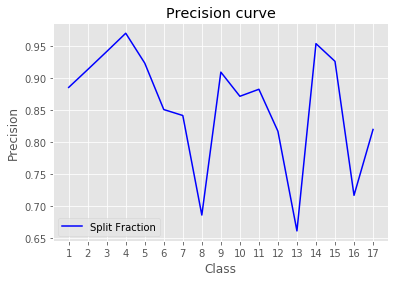

In [38]:
import matplotlib.pyplot as plt

b=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
plt.plot(b, p, 'b', label='Split Fraction')
plt.title('Precision curve')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.legend()

plt.show()

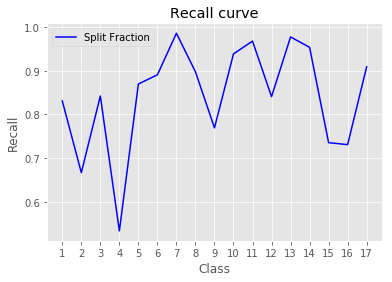

In [39]:
import matplotlib.pyplot as plt

b=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
plt.plot(b, r, 'b', label='Split Fraction')
plt.title('Recall curve')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [45]:
f=list()
c=0
for i in range(len(r)):
    c=(2*p[i]*r[i])/(p[i]+r[i])
    f.append(c)
print(len(f))

17


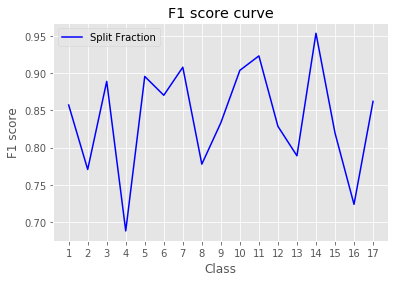

In [47]:
import matplotlib.pyplot as plt

b=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
plt.plot(b, f, 'b', label='Split Fraction')
plt.title('F1 score curve')
plt.xlabel('Class')
plt.ylabel('F1 score')
plt.legend()

plt.show()

In [49]:
avgp=0
c=0
for i in range(len(p)):
    c=c+p[i]
avgp=(c/17)
print("avg precision",avgp)

avg precision 0.8569472817226003


In [50]:
avgr=0
c=0
for i in range(len(r)):
    c=c+r[i]
avgr=(c/17)
print("avg Recall",avgr)

avg Recall 0.8434202473330981


In [51]:
avgf=0
c=0
for i in range(len(f)):
    c=c+f[i]
avgf=(c/17)
print("avg F1 score",avgf)

avg F1 score 0.840763829890078
